In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

# Local import 

from spectra.py_spectra import *

# Two levels that are used to create mean analysis

analysis_levels  = [10,25]

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)



In [11]:
#-----------------------------------------------------------------
def run_spectral_analysis(in_dir, out_dir, day, nam = False):

    hrrr_dir  = str(os.path.join(in_dir, day, "hrrr"))
    rrfs0_dir = str(os.path.join(in_dir, day, "ctrl"))
    rrfs1_dir = str(os.path.join(in_dir, day, "nord3"))
    
    if nam == True:
        print("NAM analysis requested, will be added\n")
        nam_dir = str(os.path.join(in_dir, day, "nam"))

    # Open data sets

    hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
    rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
    rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")
    
    if nam == True:
        nam = open_mfdataset_list(nam_dir, "region_*.nc")

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these five levels are averaged together

        klevels = [k-2, k-1, k, k+1, k+2]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
        hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
        hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

        hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


        rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
        rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
        rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

        rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

        rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
        rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
        rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

        rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)
        
        if nam == True:

            nam_u = np.nan_to_num(nam.U.isel(nz=klevels).values).astype('float64')
            nam_v = np.nan_to_num(nam.V.isel(nz=klevels).values).astype('float64')
            nam_w = np.nan_to_num(nam.W.isel(nz=klevels).values).astype('float64')

            nam_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        ylim = [0.01,1.0e4]
        axis = 0
        func = get_spectra2D_POWSPEC

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True)
        plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim)
        
        if nam == True:
            plot_spectra(nam_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim)
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim)
        else:
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=ylim)
            
        ax1 = fig.add_subplot(gs[0, 1])
        ylim = [1000.,1.0e10]

        plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True)
        plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim)

        if nam == True:
            plot_spectra(nam_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim)
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim)
        else:
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=ylim)

        plt.suptitle("CASE DAY: %s_%s_%s %s UTC \n Pressure Level: %d hPa" % (day[0:4],day[4:6],day[6:8],day[8:10],hrrr.pres[k]/100), fontsize=20)

        plt.savefig("%s/spectra_%s_%3.3dhPa.pdf" % (out_dir, day, hrrr.pres[k]/100),bbox_inches='tight')

        plt.show()

Running day:  2021052612

NAM analysis requested, will be added


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_s

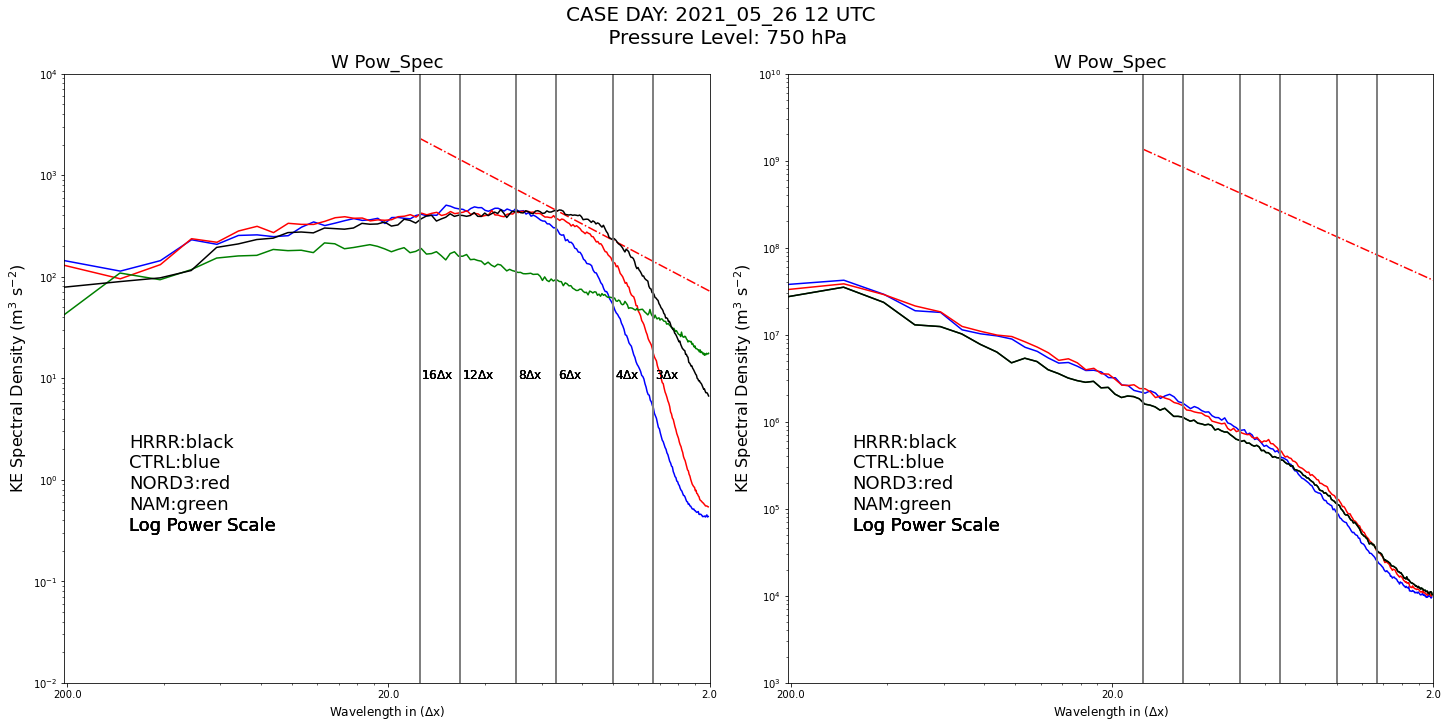


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped 

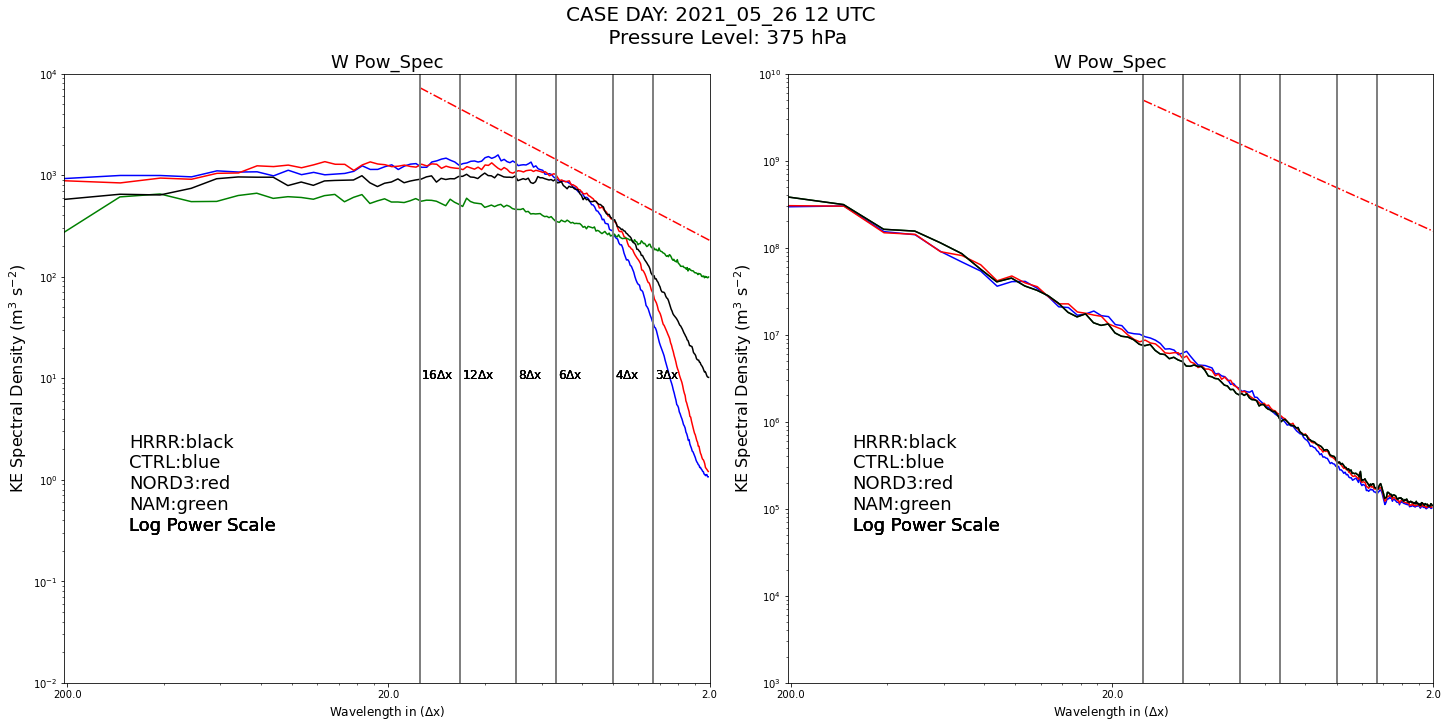

In [12]:
in_dir  = "/work/larissa.reames"
out_dir = "/work/wicker/CAM_case_studies"
day     = ["2021052612"]

for d in day:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d, nam=True)